# Clase 4. Preparación de datos.
## Sección 2. Discretización

Este cuaderno contiene los ejemplos en python/SKLearn que acompañan a la [presentación de la clase](../ceia_add_clase5.pdf).

Ejemplos organizados por sección:

- Discretización por cuantil, uniforme, k-means
- Discretización con árboles de decisión

In [4]:
%load_ext autoreload
%autoreload 2

# Importamos librerías 
import pandas as pd
import numpy as np
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import scipy.stats as stats

# Entrenamiento de modelos de prueba
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Evaluación de modelos de prueba
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

# Partición de train-test set
from sklearn.model_selection import train_test_split

# Pipelines
from sklearn.pipeline import Pipeline

# Crear datasets
from sklearn.datasets import make_regression

# Esquemas de entrenamiento
from sklearn.model_selection import RepeatedStratifiedKFold, RepeatedKFold
from sklearn.model_selection import cross_val_score

np.random.seed(42)

# Versiones de librerías
print("".join(f"{x[0]}:{x[1]}\n" for x in [
    ("Pandas",pd.__version__),
    ("Numpy",np.__version__),
    ("Matplotlib",matplotlib.__version__),
    ("SKlearn",sklearn.__version__),
    ("Seaborn",sns.__version__)
]))

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Pandas:2.0.3
Numpy:1.24.4
Matplotlib:3.7.5
SKlearn:1.3.2
Seaborn:0.13.2



Datasets.

In [2]:
DATASET_PATH="./data"
!ls {DATASET_PATH}

diabetes.csv  diabetes_ex.csv  houseprices.csv	housing_ex.csv	titanic.csv


## Preparación de datos

Carga de datasets utilizados para ejemplos.

Titanic.

In [45]:
df_titanic = pd.read_csv(DATASET_PATH+"/titanic.csv")
df_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [46]:
def display_dataset_distributions(dataset):
    fig = dataset.hist(xlabelsize=12, ylabelsize=12,figsize=(22,10))
    [x.title.set_size(14) for x in fig.ravel()]
    plt.tight_layout()
    plt.show()

## 3. Discretización

### 3.1 Discretización por cuantil, uniforme, k-means

- Es el proceso de transformar variables cuantitativas en un conjunto de dos o más categorías.
- A menudo se le llama *binning* o *k-bins* donde *k* es la cantidad de grupos a formar.
- Los criterios más utilizados para formar los grupos son:
    - **Uniforme**: cada bin tiene el mismo tamaño de intervalo de valores posibles que puede tomar la variable.
    - **Cuantil**: cada bin tiene la misma cantidad de valores, el particionamiento se basa en percentiles.
    - **Cluster**: se forman grupos utilizando algún algoritmo de asignación, como por ejemplo k-means.

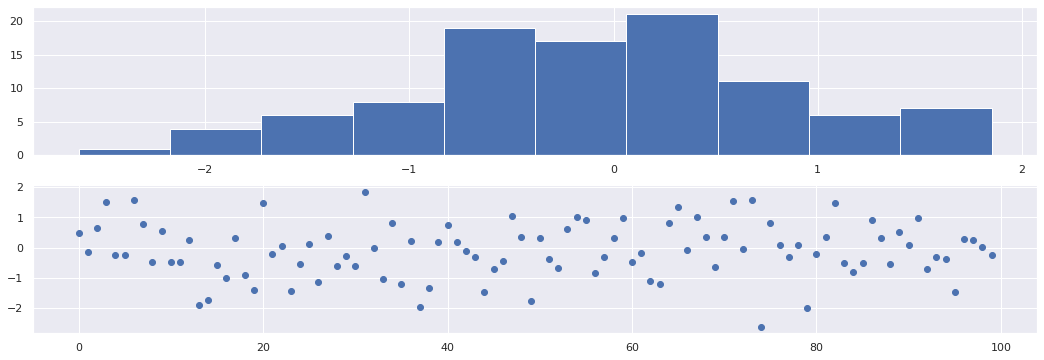

In [6]:
from sklearn.preprocessing import KBinsDiscretizer

data = np.random.normal(size=100)
fig,axes = plt.subplots(2,figsize=(18,6))
axes[0].hist(data, bins=10);
axes[1].scatter(np.arange(0,data.shape[0]),data);

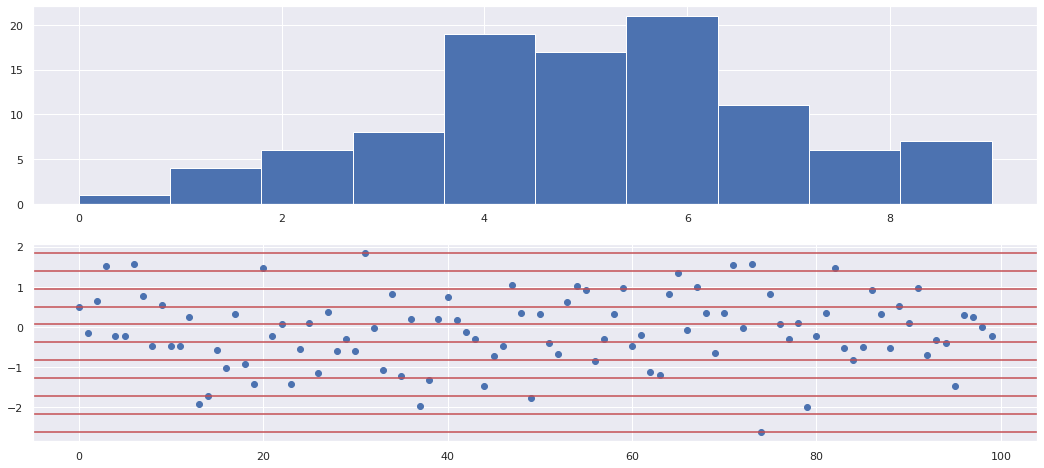

In [8]:
kbins = KBinsDiscretizer(n_bins=10, encode= 'ordinal' , strategy= 'uniform' )
data_tf = kbins.fit_transform(data.reshape(-1,1))
fig,axes = plt.subplots(2,figsize=(18,8))
axes[0].hist(data_tf, bins=10);
axes[1].scatter(np.arange(0,data.shape[0]),data)
[axes[1].axhline(x,color='r') for x in kbins.bin_edges_[0]];

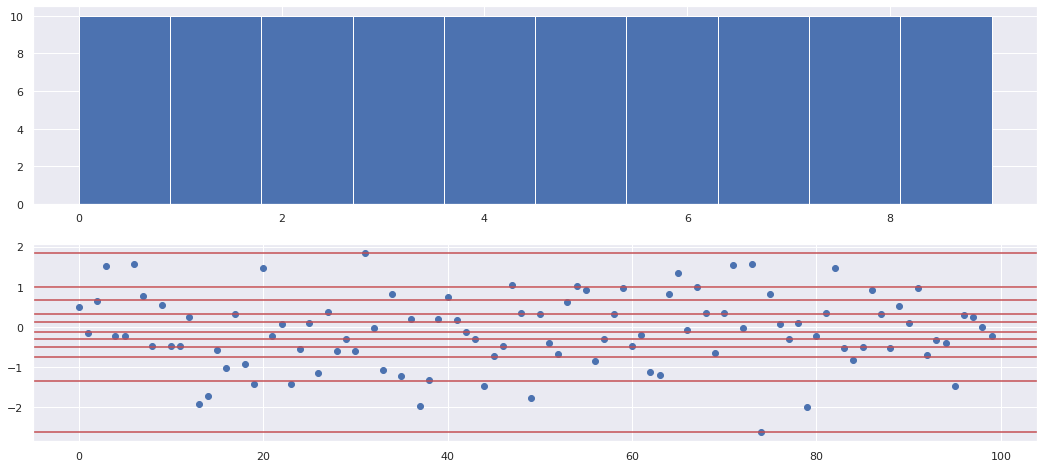

In [10]:
kbins = KBinsDiscretizer(n_bins=10, encode= 'ordinal' , strategy= 'quantile' )
data_tf = kbins.fit_transform(data.reshape(-1,1))
fig,axes = plt.subplots(2,figsize=(18,8))
axes[0].hist(data_tf, bins=10);
axes[1].scatter(np.arange(0,data.shape[0]),data)
[axes[1].axhline(x,color='r') for x in kbins.bin_edges_[0]];

#### Ejemplo con Titanic

En este ejemplo se muestran el efecto de los métodos anteriores de formación de bins sobre el dataset de Titanic. No se comparará el efecto en un modelo, pero sí se verá la distribución y como quedan repartidos en train y test.

In [3]:
df_titanic = pd.read_csv(DATASET_PATH+"/titanic.csv",usecols=['Age', 'Fare', 'Survived'])
df_titanic.head()

,Survived,Age,Fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500


In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    df_titanic[['Age', 'Fare']],
    df_titanic['Survived'],
    test_size=0.3,
    random_state=42)

X_train.shape, X_test.shape

((623, 2), (268, 2))

Función para imputar con muestreo aleatorio.

In [5]:
def impute_na_with_random_sampling(data, X_train, variable):
    """ Recibe una serie y devuelve .
    data: dataset a imputar
    X_train: origen de muestras
    variable: nombre de variable a imputar
    """
    # Crear una copia para no modificar el dataframe original
    df = data.copy()
    
    # Crear una copia temporal de la variable a imputar
    df[variable+'_random'] = df[variable]
    
    # Muestreo aleatorio de N muestras de X_train (N=cantidad de NAs)
    random_sample = X_train[variable].dropna().sample(df[variable].isnull().sum(), random_state=42)

    # Alineado de índices. Esto es porque merge() de pandas requiere que coincidan los índices de ambas series.
    random_sample.index = df[df[variable].isnull()].index
    
    # Asignar la muestra aleatoria a las posiciones con NA.
    df.loc[df[variable].isnull(), variable+'_random'] = random_sample

    return df[variable+'_random']

In [21]:
# Age
X_train['Age'] = impute_na_with_random_sampling(df_titanic, X_train, 'Age')
X_test['Age'] = impute_na_with_random_sampling(df_titanic, X_test, 'Age')

# Fare
X_train['Fare'] = impute_na_with_random_sampling(df_titanic, X_train, 'Fare')
X_test['Fare'] = impute_na_with_random_sampling(df_titanic, X_test, 'Fare')

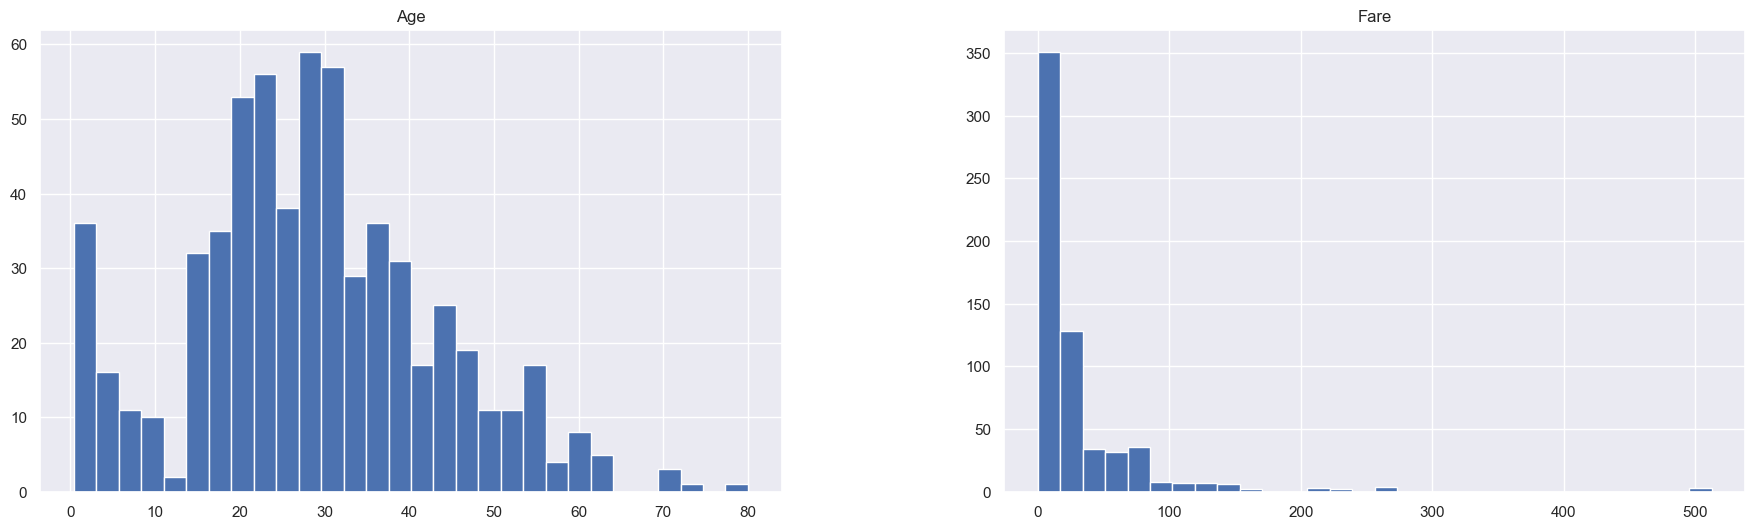

In [7]:
X_train[['Age', 'Fare']].hist(bins=30, figsize=(22,6));

/home/juanma/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/home/juanma/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7ff1355d8700>
Traceback (most recent call last):
  File "/home/juanma/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/h

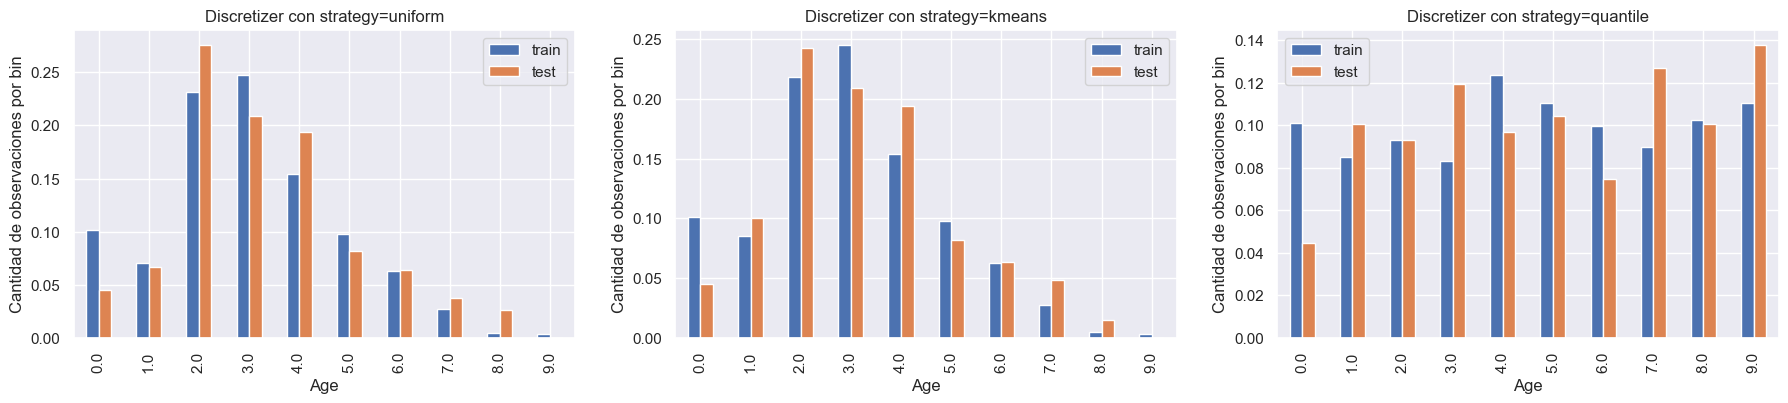

In [27]:
from sklearn.preprocessing import KBinsDiscretizer

discretizers = [
    ("uniform", KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')),    
    ("kmeans", KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='kmeans')),
    ("quantile", KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile'))
]
     
fig,axes=plt.subplots(1,len(discretizers),figsize=(22,4))

for i,d in enumerate(discretizers):
    name,disc = d[0],d[1]
    disc.fit(X_train[['Age', 'Fare']])
    #disc.bin_edges_
    
    train_t = disc.transform(X_train[['Age', 'Fare']])
    train_t = pd.DataFrame(train_t, columns = ['Age', 'Fare'])
    train_t.head()
    
    test_t = disc.transform(X_test[['Age', 'Fare']])
    test_t = pd.DataFrame(test_t, columns = ['Age', 'Fare'])
     
    t1 = train_t.groupby(['Age'])['Age'].count() / len(train_t)
    t2 = test_t.groupby(['Age'])['Age'].count() / len(test_t)
     
     
    tmp = pd.concat([t1, t2], axis=1)
    tmp.columns = ['train', 'test']
    tmp.plot.bar(ax=axes[i])
    axes[i].set_title("Discretizer con strategy={}".format(name));
    axes[i].set_ylabel('Cantidad de observaciones por bin');

Observación:
- En el caso de las estrategias 'uniform' y 'kmeans', quedaron algunas variables con muy baja representación en el test set.

### 3.3 Discretización con árboles de decisión

La discretización con árboles de decisión consiste en aprovechar los intervalos hallados por las hojas del árbol como criterio de discretización.

Los pasos son:

1. Entrenar un árbol de decisión con una profundidad límite (se recomienda que no sea mayor a 4) usando la variable que se quiere discretizar y la variable objetivo.
2. Reemplazar los valores de la variable por la salida del árbol.

Ejemplo: discretización de la variable 'age' y variable objetivo 'Survived'. Es decir, entrenamos el árbol para predecir si un pasajero sobrevivió o no en función de su edad.

In [9]:
# Particionado de dataset como se vió en los ejemplos anteriores
X_train, X_test, y_train, y_test = train_test_split(
    df_titanic[['Age', 'Fare']],
    df_titanic['Survived'],
    test_size=0.3,
    random_state=42)

X_train.shape, X_test.shape

((623, 2), (268, 2))

In [10]:
# El árbol de decisión requiere que no haya entradas NaN. En este caso se imputa por muestreo aleatorio.
X_train['Age'] = impute_na_with_random_sampling(df_titanic, X_train, 'Age')
X_test['Age'] = impute_na_with_random_sampling(df_titanic, X_train, 'Age')
#X_train['Fare'] = impute_na_with_random_sampling(df_titanic, X_train, 'Fare')
#X_test['Fare'] = impute_na_with_random_sampling(df_titanic, X_train, 'Fare')

In [36]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import cross_val_score

# Instanciar un árbol con dos niveles de profundidad
tree_model = DecisionTreeClassifier(criterion="gini", max_depth=2)

# Entrenar utilizando la variable Age unicamente (recordar que y_train contiene Survived)
tree_model.fit(X_train['Age'].to_frame(), y_train)

# Crear una nueva variable que contiene la probabilidad de supervivencia(0=no sobrevivió, 1=sobrevió).
# Notar que en este caso habrá 4 valores (más adelante se muestra el diagrama del árbol con estos valores)
X_train['Age_tree'] = tree_model.predict_proba(X_train['Age'].to_frame())[:,1]
X_train[['Age','Age_tree']].head(10)

,Age,Age_tree
445,4.0,0.473684
650,44.0,0.354386
172,1.0,0.625000
450,36.0,0.354386
314,43.0,0.354386
332,38.0,0.354386
801,31.0,0.354386
90,29.0,0.354386
834,18.0,0.354386
181,18.0,0.354386


Un árbol de profundidad 2, creará cuatro bins, por lo tanto tendremos 4 valores posibles.

In [38]:
# Puntos creados por el árbol
X_train['Age_tree'].unique()

array([0.47368421, 0.35438596, 0.625     , 0.85714286])

Cada uno de estos valores representa la probabilidad de supervivencia. Observar que en el caso anterior se muestran las probabilidades.

In [14]:
threeshold = 0.5
['Survived' if x > threeshold else 'Died' for x in X_train['Age_tree'].unique()]

['Died', 'Died', 'Survived', 'Survived']

- **gini**: indica la "pureza". Valores mayores que cero indican que el nodo/hoja contiene muestras de distintas clases [Gini impurity](https://bambielli.com/til/2017-10-29-gini-impurity/)
- **samples**: cantidad de muestras que caen en ese nodo/hoja.
- **values**: cantidad de valores de cada clase.
- **class**: predicción que haría el nodo, que corresponde con la clase de mayor aparición.

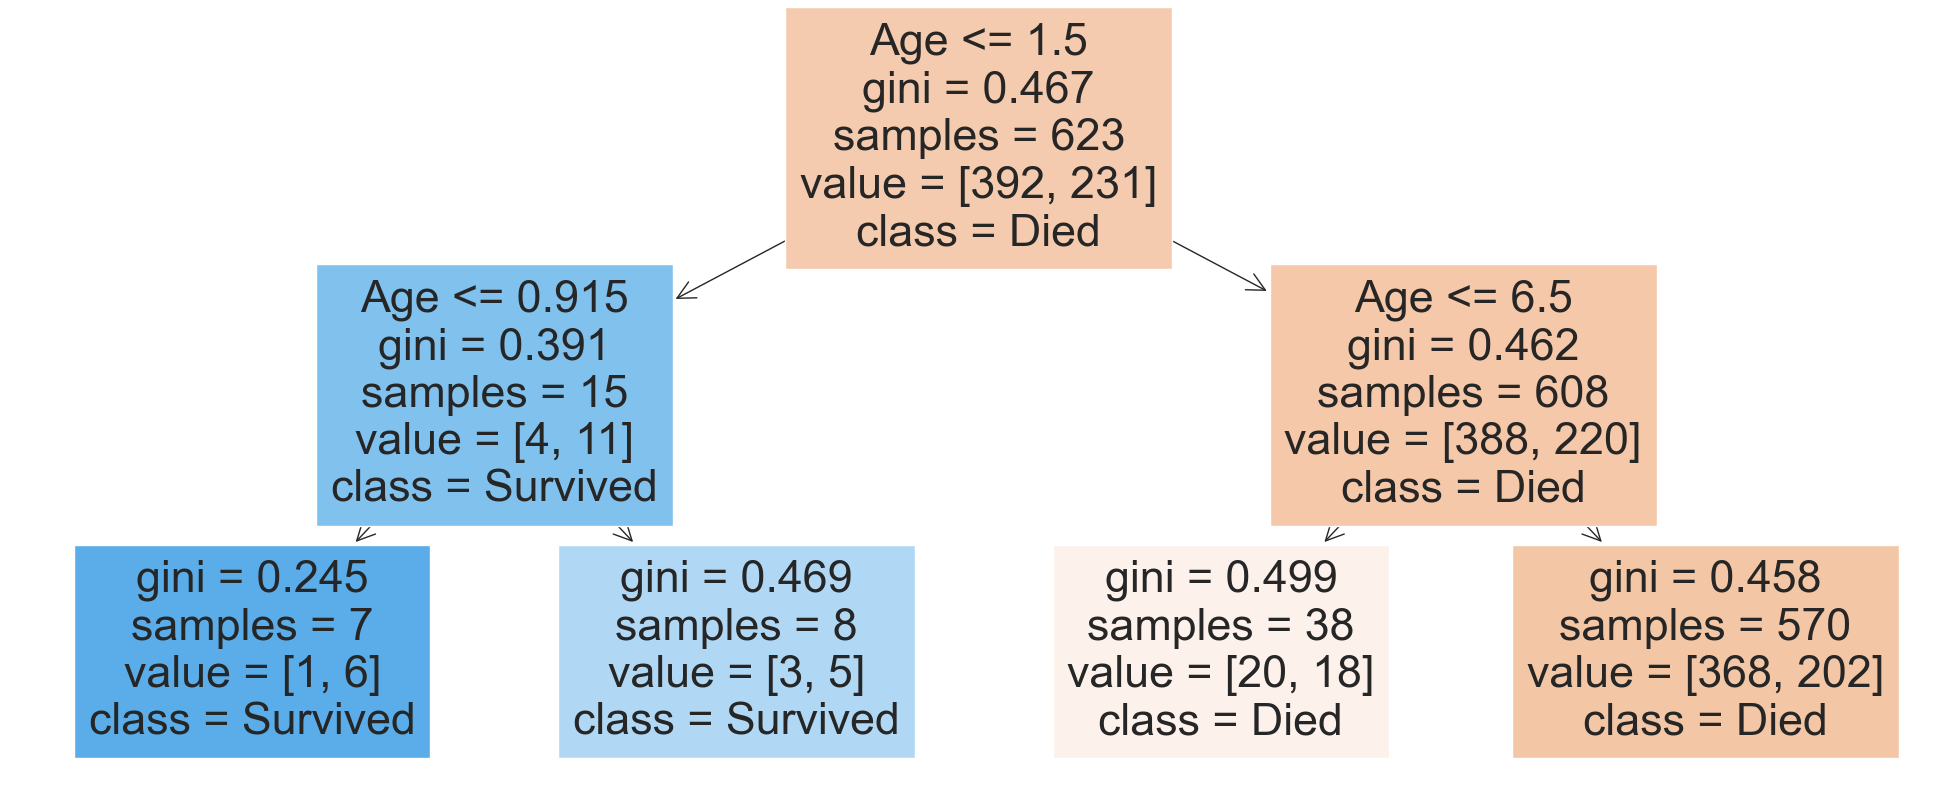

In [37]:
from sklearn import tree
fig = plt.figure(figsize=(25,10))
_ = tree.plot_tree(tree_model, feature_names=['Age'], class_names=['Died','Survived'], filled=True)

El árbol puede interpretarse como una secuencia de múltiples if-else. En este caso:

~~~python
if Age <= 1.5:
    if Age <= 0.915:
        return 'Survived'
    else:
        return 'Survived'
else:
    if Age <= 6.5:
        return 'Died'
    else:
        return 'Died'
~~~

En este caso, es fácil notar que se podría haber utilizado una profundidad menor.

A continuación se representará la variable Age_tree que puede tomar los 4 valores vistos anteriormente contra la variable objetivo (en este caso su promedio para ese valor codificado). 

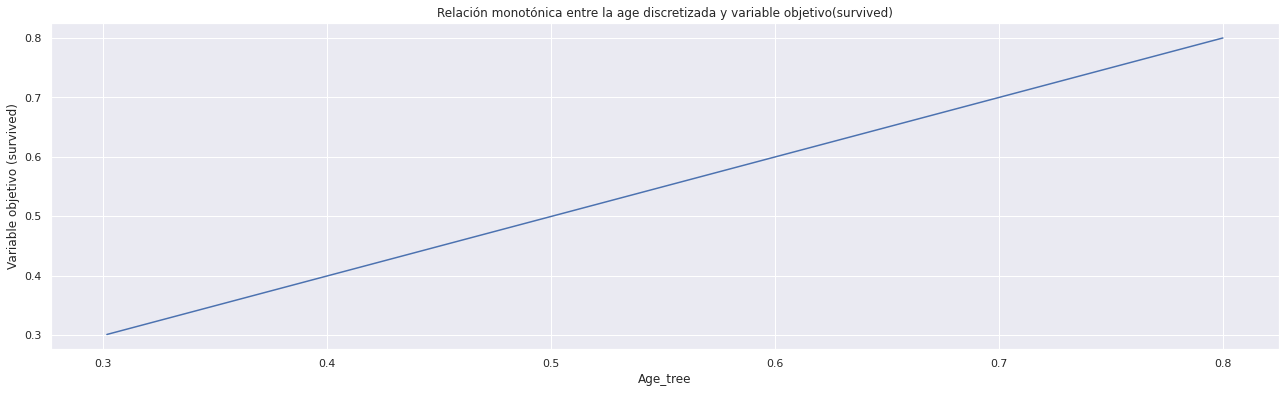

In [39]:
pd.concat([X_train, y_train], axis=1).groupby(['Age_tree'])['Survived'].mean().plot(figsize=(22,6));
plt.title('Relación monotónica entre la age discretizada y variable objetivo(survived)')
plt.ylabel('Variable objetivo (survived)');

Observación:
- En train, existe una relación monotónica.

Cantidad de pasajeros por cada división.

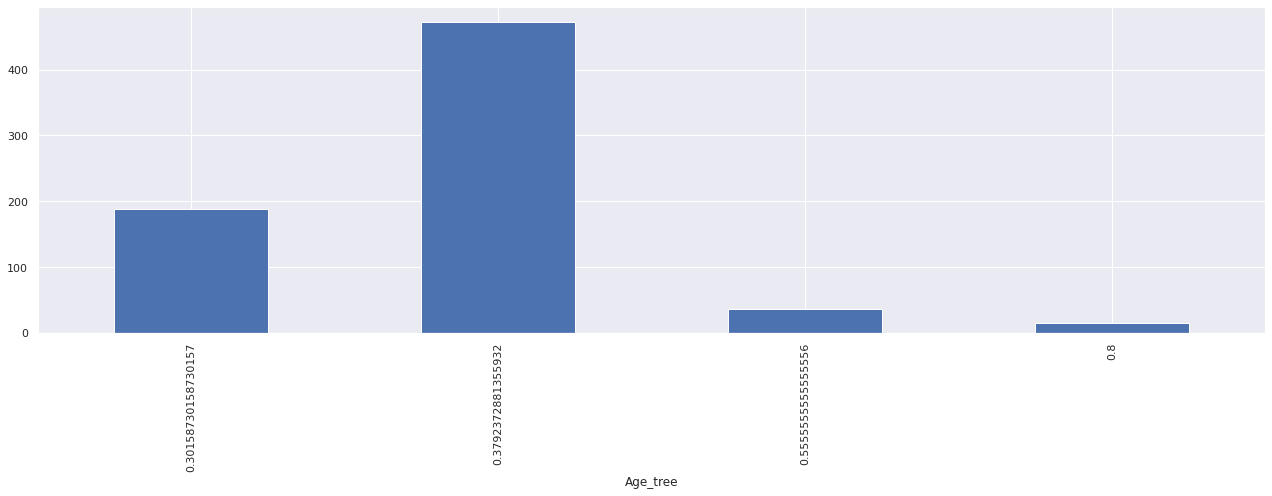

In [40]:
X_train.groupby(['Age_tree'])['Age'].count().plot.bar(figsize=(22,6));

Exploración de intervalos de bins generados.

In [41]:
pd.concat( [X_train.groupby(['Age_tree'])['Age'].min(),
            X_train.groupby(['Age_tree'])['Age'].max()], axis=1)

,Age,Age
Age_tree,,
0.301587,7.00,23.0
0.379237,24.00,80.0
0.555556,2.00,6.0
0.800000,0.42,1.0


El árbol generado creó los siguientes intervalos:
- Edad de 7 a 21 años.
- Edad de 22 a 80 años.
- Edad de 0 a 3 años.
- Edad de 4 a 6 años.

A continuación se representará la variable Age_tree que puede tomar los 4 valores vistos anteriormente contra la variable objetivo (en este caso su promedio para ese valor codificado), pero a diferencia del caso anterior, ahora se hará sobre el test set. 

Recordar que el objetivo es obtener una relación monotónica.

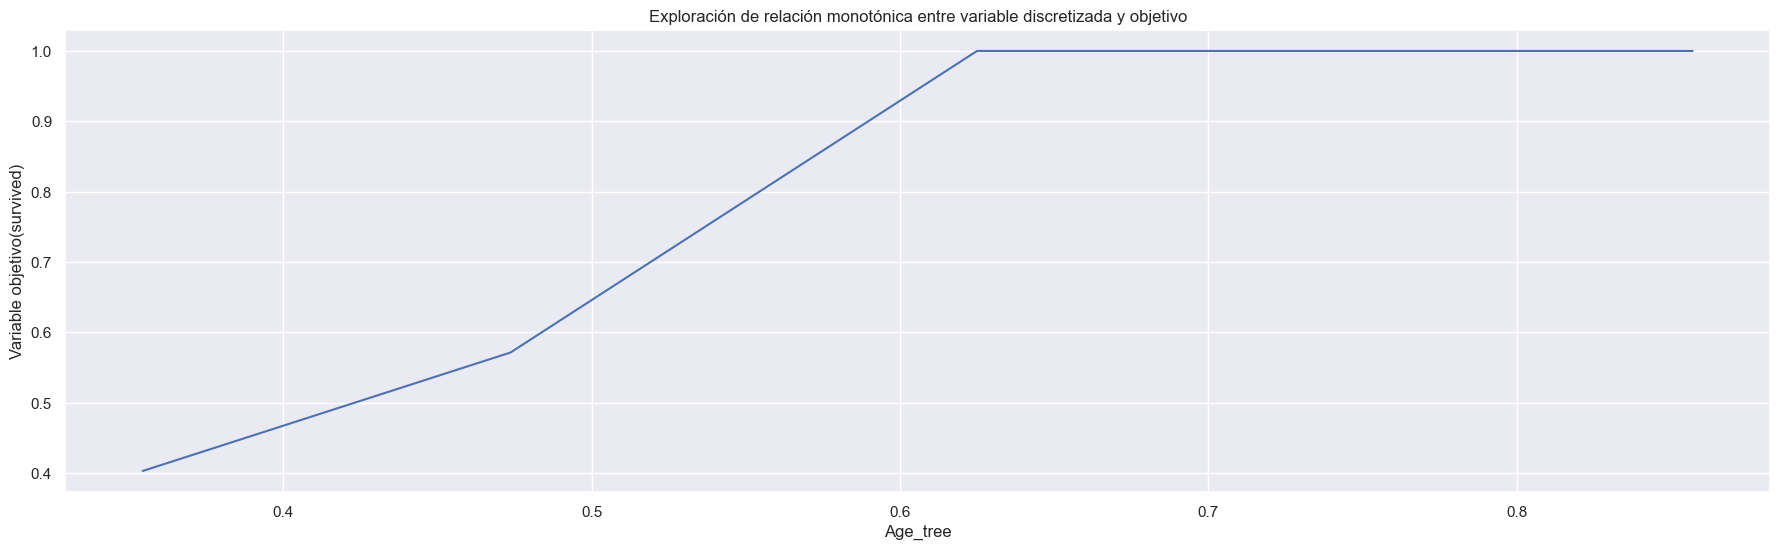

In [52]:
X_test['Age_tree'] = tree_model.predict_proba(X_test['Age'].to_frame())[:,1]
pd.concat([X_test, y_test], axis=1).groupby(['Age_tree'])['Survived'].mean().plot(figsize=(22,6))
plt.title('Exploración de relación monotónica entre variable discretizada y objetivo')
plt.ylabel('Variable objetivo(survived)');

Observación:
- En este ejemplo no se logró el objetivo de hallar una relación monotónica con la profundidad y otros HPs elegidos, pero se pueden ensayar otros parámetros.

In [53]:
score_ls = [] 
score_std_ls = []  
for tree_depth in [1, 2, 3, 4]:
    tree_model = DecisionTreeClassifier(max_depth=tree_depth)
    scores = cross_val_score(tree_model, X_train['Age'].to_frame(), y_train, cv=3, scoring='roc_auc')
    score_ls.append(np.mean(scores))
    score_std_ls.append(np.std(scores))

temp = pd.concat([pd.Series([1, 2, 3, 4]), pd.Series(score_ls), pd.Series(score_std_ls)], axis=1)

temp.columns = ['depth', 'roc_auc_mean', 'roc_auc_std']
temp.sort_values('roc_auc_mean',ascending=False)

,depth,roc_auc_mean,roc_auc_std
0,1,0.503243,0.005718
2,3,0.497957,0.008346
1,2,0.476861,0.019470
3,4,0.471041,0.015992


Se observa que de los parámetros ensayados el que tiene mejor AUC es el árbol con profundidad 1. Se repetirá la prueba de obtener una relación monotónica con este parámetro.

In [54]:
tree_model = DecisionTreeClassifier(max_depth=1)
tree_model.fit(X_train['Age'].to_frame(), y_train)
X_train['Age_tree'] = tree_model.predict_proba(X_train['Age'].to_frame())[:, 1]
X_test['Age_tree'] = tree_model.predict_proba(X_test['Age'].to_frame())[:, 1]

In [55]:
pd.concat( [X_train.groupby(['Age_tree'])['Age'].min(),
            X_train.groupby(['Age_tree'])['Age'].max()], axis=1)

,Age,Age
Age_tree,,
0.361842,2.00,80.0
0.733333,0.42,1.0


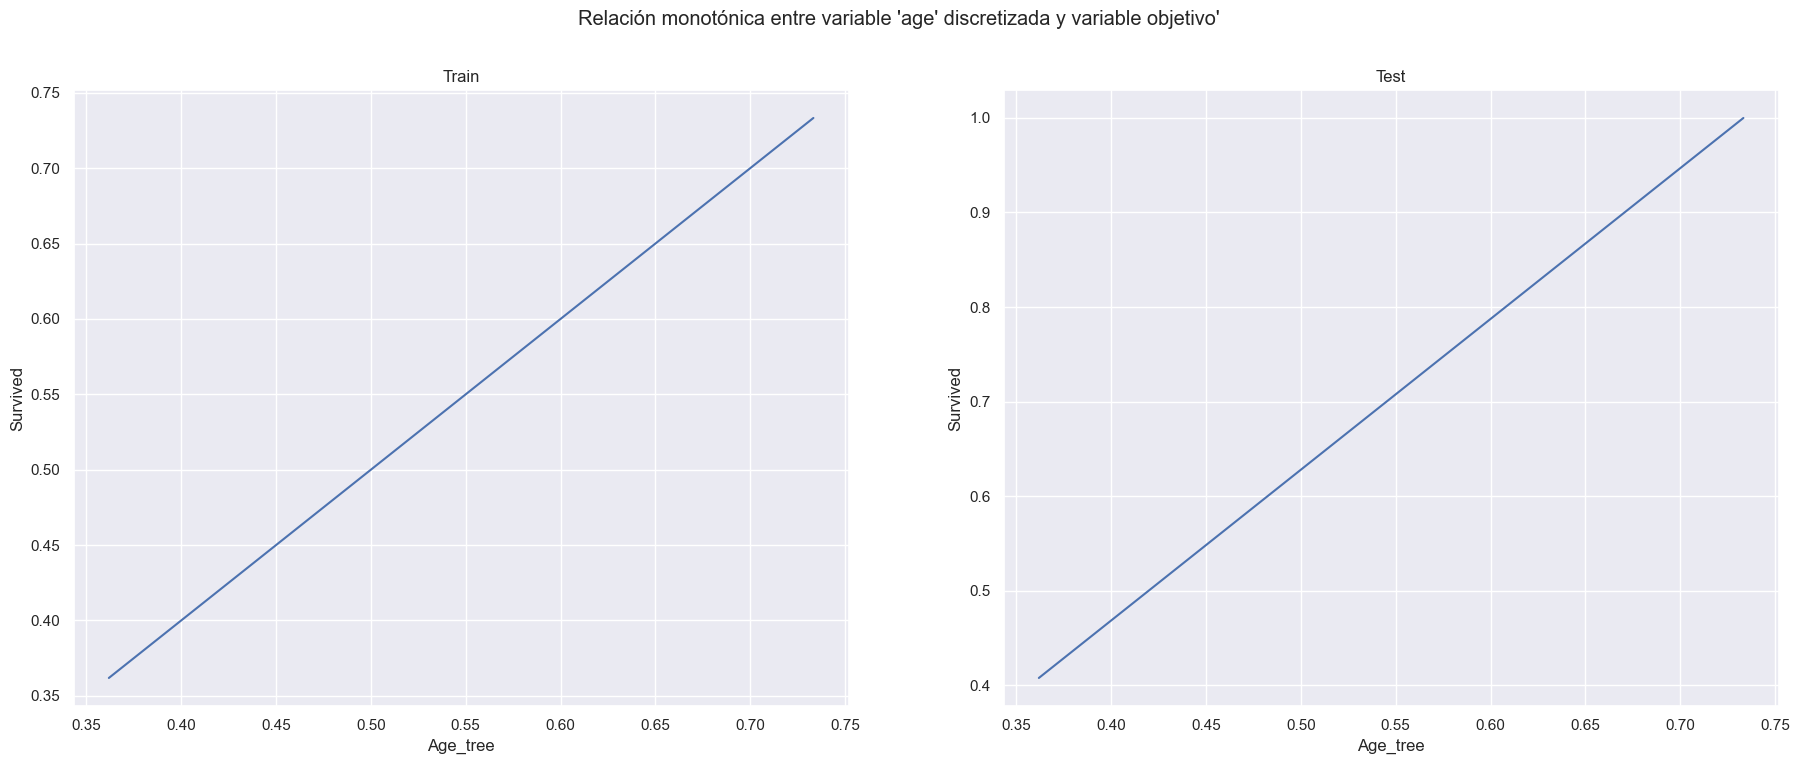

In [56]:
fig,axes = plt.subplots(1,2,figsize=(22,8))
fig.suptitle("Relación monotónica entre variable 'age' discretizada y variable objetivo'")
pd.concat([X_train, y_train], axis=1).groupby(['Age_tree'])['Survived'].mean().plot(ax=axes[0])
axes[0].set_ylabel('Survived')
axes[0].set_title("Train")

X_test['Age_tree'] = tree_model.predict_proba(X_test['Age'].to_frame())[:,1]
pd.concat([X_test, y_test], axis=1).groupby(['Age_tree'])['Survived'].mean().plot(ax=axes[1])
axes[1].set_ylabel('Survived')
axes[1].set_title("Test");

- Observación: con el nuevo modelo, se obtuvo una relación monotónica en train y test set.